In [134]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    print(data.shape[1])
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# load dataset
dataset = read_csv('data/data4.csv',usecols=["LME_PR_AL_serie_ROC_7", "LME_PR_AL_serie_MOM_15", "LME_PR_AL_serie_MOM_30", "LME_PR_AL_serie_close"])
values = dataset.values
reframed =  series_to_supervised(values,1, 1)
# ensure all data is float
values = reframed.astype('float32')

4


In [135]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [136]:
# specify the number of lag hours


# split into train and test sets
#values = reframed.values
#print(values.shape)
n_train_hours = 1250
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]
print("test")
print (test.shape)
print("train")
print (train.shape)


# split into input and outputs
n_obs = 1000
# n_obs = n_hours
n_features = 4
n_hours = 2
print (train[:, -n_features])
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])


test
(122, 8)
train
(1250, 8)
[ 0.00649836  0.00203537  0.00256531 ...,  0.00882454  0.00798815
  0.0087662 ]
(1250, 8) 1250 (1250,)
(1250, 2, 4) (1250,) (122, 2, 4) (122,)


Train on 1250 samples, validate on 122 samples
Epoch 1/20
 - 0s - loss: 0.0117 - acc: 8.0000e-04 - val_loss: 0.0228 - val_acc: 0.0000e+00
Epoch 2/20
 - 0s - loss: 0.0099 - acc: 8.0000e-04 - val_loss: 0.0267 - val_acc: 0.0000e+00
Epoch 3/20
 - 0s - loss: 0.0102 - acc: 8.0000e-04 - val_loss: 0.0250 - val_acc: 0.0000e+00
Epoch 4/20
 - 0s - loss: 0.0070 - acc: 8.0000e-04 - val_loss: 0.0099 - val_acc: 0.0000e+00
Epoch 5/20
 - 0s - loss: 0.0034 - acc: 8.0000e-04 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 6/20
 - 0s - loss: 0.0016 - acc: 8.0000e-04 - val_loss: 0.0091 - val_acc: 0.0000e+00
Epoch 7/20
 - 0s - loss: 0.0016 - acc: 8.0000e-04 - val_loss: 0.0093 - val_acc: 0.0000e+00
Epoch 8/20
 - 0s - loss: 0.0017 - acc: 8.0000e-04 - val_loss: 0.0095 - val_acc: 0.0000e+00
Epoch 9/20
 - 0s - loss: 0.0030 - acc: 8.0000e-04 - val_loss: 0.0123 - val_acc: 0.0000e+00
Epoch 10/20
 - 0s - loss: 0.0024 - acc: 8.0000e-04 - val_loss: 0.0100 - val_acc: 0.0000e+00
Epoch 11/20
 - 0s - loss: 0.0051 - acc: 8.

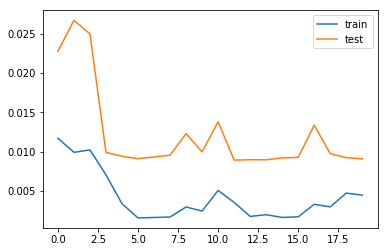

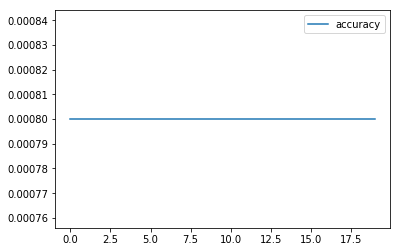

In [137]:
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# plot history
pyplot.plot(history.history['acc'], label='accuracy')
pyplot.legend()
pyplot.show()


In [138]:
print(test_X.shape)
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(test_X.shape)
# make a prediction
yhat = model.predict(test_X)
print(yhat.shape)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
print(test_X.shape)

# invert scaling for forecast
print(yhat.shape)
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
print("inv_hat")

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
#rmse = sqrt(mean_squared_error(yhat, test_X[:, -1:]))
print('Test RMSE: %.3f' % rmse)

(122, 2, 4)
(122, 2, 4)
(122, 1)
(122, 8)
(122, 1)
inv_hat
Test RMSE: 0.969
